Problem statement: to detect wheatheads present in images of wheats

# Outline

**0. References **

**1. Pipeline **

**2. Importing necessary packages**

**3. Basic EDA **

**4. Data Preparation **

**5. Model **

**6. Training**

**7. Inference**

## 1. Pipeline

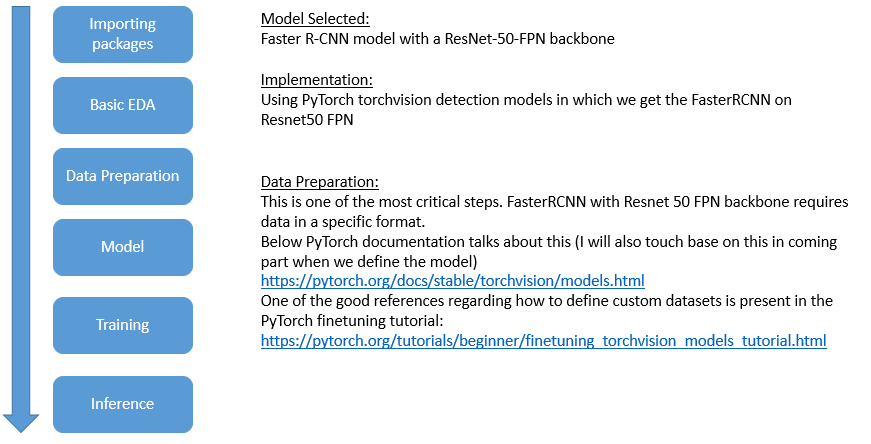

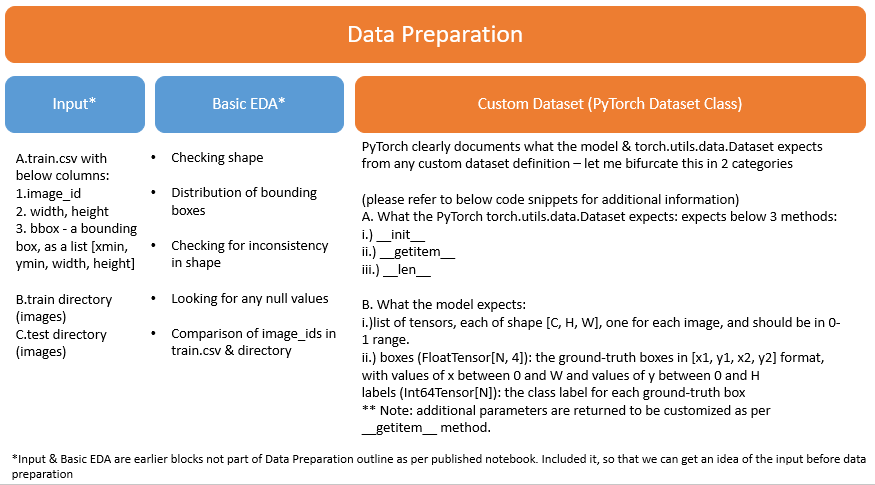

## 2. Importing Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import cv2

import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms

import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import random

## 3. Basic EDA

In [2]:
os.listdir("/kaggle/input/global-wheat-detection")

train_dir = "/kaggle/input/global-wheat-detection/train"
test_dir = "/kaggle/input/global-wheat-detection/test"

df_train=pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")

In [3]:
print(df_train.head())
print(df_train.shape)

    image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1
(147793, 5)


So we are looking at 147793 entries in the training excel -> corresponding to the total number of bounding boxes overall
This may/may not be equal to the number of images -- lets check this
It will be equal only if each image has one and only one bounding box

In [4]:
print(len(df_train['image_id'].unique()))
print((df_train.shape[0])/len(df_train['image_id'].unique()))

3373
43.8164838422769


Thus we have 3373 images. And we are looking at an average of approximately 44 bounding boxes in the image
=> Thus approximately 44 wheat heads are present in an image

Lets also have a look at the distribution in terms of max & min

In [5]:
print("Image_id v/s # of bounding boxes")
print(df_train['image_id'].value_counts())

Image_id v/s # of bounding boxes
35b935b6c    116
f1794c924    108
f79336a8e    104
134d4a01c    101
b70c20580     97
            ... 
86296fc32      1
a5cb30c38      1
41457a646      1
47a1184e4      1
76595919e      1
Name: image_id, Length: 3373, dtype: int64


Checking  image sizes

In [6]:
print("Height")
print(df_train['height'].value_counts())
print("Width")
df_train['width'].value_counts()

Height
1024    147793
Name: height, dtype: int64
Width


1024    147793
Name: width, dtype: int64

All images have height,width = 1024,1024

Lets also check whether image_ids in df_train csv and list of images in training folder are same

In [7]:
list_image_ids_df = list(df_train['image_id'].unique())
list_image_ids_dir = os.listdir("/kaggle/input/global-wheat-detection/train")
#list_image_ids_df.sort() == list_image_ids_dir.sort()
#sorted(list_image_ids_df,key = lambda x: x,reverse=False)

In [8]:
len(list_image_ids_dir)- len(list_image_ids_df)

49

In [9]:
#There is a difference of 49 images i.e. there are 49 images in training directory for which there are no bounding boxes indicating no wheatheads detected

Just to be sure, lets check for any null values in dataframe

In [10]:
for col in df_train.columns:
    if sum(df_train[col].isnull())==1:
        print(col+" has null values")
    else:
        print(col+" no null values")

image_id no null values
width no null values
height no null values
bbox no null values
source no null values


Now, that the different sets of checks are done lets start with data preparation

## 4. Data Preparation

We know the structure df_train from the given data description:
1. image_id - the unique image ID
2. width, height - the width and height of the images
3. bbox - a bounding box, formatted as a Python-style list of [xmin, ymin, width, height]

bbox is something of high interest to us. We need to structure bbox in a way that can be used further

In [11]:
df_train['x0'] = df_train['bbox'].map(lambda x: x[1:-1].split(",")[0]).astype(float)
df_train['y0'] = df_train['bbox'].map(lambda x: x[1:-1].split(",")[1]).astype(float)
df_train['w'] = df_train['bbox'].map(lambda x: x[1:-1].split(",")[2]).astype(float)
df_train['h'] = df_train['bbox'].map(lambda x: x[1:-1].split(",")[3]).astype(float)
df_train['x1'] = df_train['x0'] + df_train['w']
df_train['y1'] = df_train['y0'] + df_train['h']

In [12]:
df_train.head()

,image_id,width,height,bbox,source,x0,y0,w,h,x1,y1
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,890.0,258.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,356.0,606.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,451.0,664.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,943.0,202.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,150.0,261.0


In [13]:
for col in df_train.columns:
    if sum(df_train[col].isnull())==1:
        print(col+" has null values")
    else:
        print(col+" no null values")

image_id no null values
width no null values
height no null values
bbox no null values
source no null values
x0 no null values
y0 no null values
w no null values
h no null values
x1 no null values
y1 no null values


In [14]:
df_train.dtypes

image_id     object
width         int64
height        int64
bbox         object
source       object
x0          float64
y0          float64
w           float64
h           float64
x1          float64
y1          float64
dtype: object

In [15]:
cols_to_be_selected = ['image_id','x0','y0','x1','y1']
df1_train = df_train[cols_to_be_selected]

In [16]:
val_percentage = 0.2
num_val_images = int(len(df1_train['image_id'].unique())*val_percentage)
num_train_images = len(df1_train['image_id'].unique()) - num_val_images
list_val_imageid = list(df1_train['image_id'].unique())[(-1)*num_val_images:]
list_train_imageid = list(df1_train['image_id'].unique())[:num_train_images]

In [17]:
print("Number of validation images: ",num_val_images)
print("Number of training images: ",num_train_images)
print(num_val_images + num_train_images)

Number of validation images:  674
Number of training images:  2699
3373


Now lets create corresponding dataframes

In [18]:
df2_val = df1_train.loc[df1_train['image_id'].isin(list_val_imageid),:]
df2_train = df1_train.loc[df1_train['image_id'].isin(list_train_imageid),:]

With this we have the dataframes in place. Now lets start preparing the data which we need for FastRCNN Pytorch model
For this lets refer to the documentation:
https://pytorch.org/docs/stable/torchvision/models.html

In [19]:
def get_transform():
    list_transforms = []
    # converts the input image, which should be a PIL image, into a PyTorch Tensor
    list_transforms.append(transforms.ToTensor())
    
    #keeping space for augmentations in future
    
    return transforms.Compose(list_transforms)

Taking the below excerpt from the model finetuning pytorch tutorial available

Lets now define the dataset


The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.

With this in mind lets build the class with three methods in place:
1. __init__
2. __getitem__
3. __len__

In [20]:
class GlobalWheatDetectionDataset(torch.utils.data.Dataset):
    # first lets start with __init__ and initialize any objects
    def __init__(self,input_df,input_dir,transforms=None):
        
        self.df=input_df
        
        self.list_images = list(self.df['image_id'].unique())
        
        self.image_dir=input_dir
        
        self.transforms = transforms
    
    # next lets define __getitem__
    # very important to note what it returns for EACH image:
    # I. image - a PIL image of size (H,W) for ResNet50 FPN image should be scaled
    # II. target - a dictionary containing the following fields
    # A. boxes as FloatTensor of dimensions - N,4 where N = # of bounding boxs within an image 
    # and 4 columns include [x0,y0,x1,y1]
    # B. labels as Int64Tensor of dimension - N
    # C. area as Int64Tensor of dimension - N
    # D. iscrowd as UInt8Tensor of dimension - N
    # III. image_id 
    
    def __getitem__(self,idx):
        
        # II. target
        # Preparation for (A) boxes
        # FloatTensor of dimensions - N,4 where N = # of bounding boxs within an image and 4 columns include [x0,y0,x1,y1]
        
        cols_to_be_selected =['x0','y0','x1','y1']
        img_id = self.list_images[idx]
        bboxes_array = np.array(self.df.loc[self.df['image_id']==img_id,cols_to_be_selected])
        boxes = torch.tensor(bboxes_array, dtype=torch.float32)
        
        # Preparation for (B) labels
        # Int64Tensor of dimension - N
        num_boxes = self.df.loc[self.df['image_id']==img_id].shape[0]
        labels = torch.ones(num_boxes, dtype=torch.int64)
        
        # Preparation for (C) area
        # dimension - N, int64tensor
        area = torch.tensor(np.array((self.df['x1']-self.df['x0'])*(self.df['y1']-self.df['y0'])), dtype=torch.int64)
        
        # Preparation for (D) iscrowd
        # dimension - N, Uint8tensor
        iscrowd = torch.zeros(num_boxes, dtype=torch.uint8)
        
        # Combining everything
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        # I. Input image
        # Specifications: A.RGB format B. scaled (0,1) C. size (H,W) D. PIL format
        
        img = cv2.imread(self.image_dir+"/"+img_id+".jpg")
        img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_scaled = img_RGB/255.0
        img_final = img_scaled
        
        if self.transforms is not None:
            img_final = self.transforms(img_final)
        
        # III. image_id
        
        
        return img_final, target, img_id
    
    # next lets define __len__    
    def __len__(self):
        
        return len(self.df['image_id'].unique())

Thats everthing for the dataset

In [21]:
train_dataset = GlobalWheatDetectionDataset(df2_train,train_dir,get_transform())
val_dataset = GlobalWheatDetectionDataset(df2_val,train_dir,get_transform())

In [22]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [23]:
train_dataloader = DataLoader(train_dataset, batch_size=16,shuffle=False, num_workers=4,collate_fn=collate_fn)
#val_dataloader = DataLoader(val_dataset, batch_size=8,shuffle=False, num_workers=4,collate_fn=collate_fn)

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [25]:
#Showing a sample
image,targets,image_id = train_dataset[0]
# Converting the A.)images to cuda or device 
image = image.to(device)
# To see why this is needed especially in a GPU environment, try running [print(img.device) for img in images]

# Converting the B.)images to cuda or device

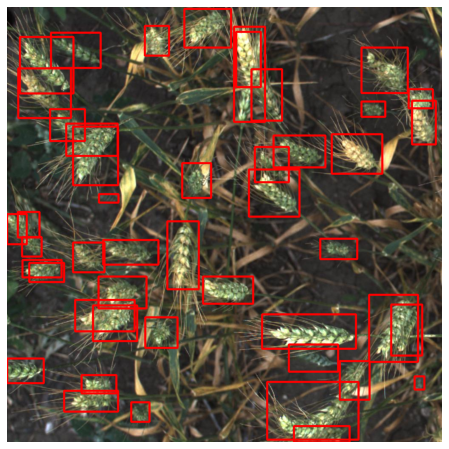

In [26]:
boxes = targets['boxes'].cpu().numpy().astype(np.int32)
sample = image.permute(1,2,0).cpu().numpy().astype(np.float32)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (255, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

## 5. Model Building

In [27]:
# load a model; pre-trained on COCO
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [28]:
def get_instance_objectdetection_model(num_classes,path_weight):
    # load an instance segmentation model pre-trained on COCO
    create_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,pretrained_backbone=False)

    # get the number of input features for the classifier
    in_features = create_model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    create_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    create_model.load_state_dict(torch.load(path_weight,map_location=torch.device('cpu')))

    return create_model

## 6. Training

In [29]:
path_weight= "/kaggle/input/fasterrcnn/fasterrcnn_resnet50_fpn_best.pth"

In [30]:
num_classes = 2
# Why 2 classes - background and wheat-heads
model = get_instance_objectdetection_model(num_classes,path_weight)

In [31]:
torch.cuda.empty_cache()

In [32]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [33]:
mode="validation"

In [34]:
if mode=="training":
    model.train()
    model.to(device)

    num_epochs = 5

    itr = 1

    for epoch in range(num_epochs):
        #loss_hist.reset()
        loss_sum = 0
        num_iterations = 0
        for images, targets, image_ids in train_dataloader:

            images = list(image.to(device,dtype=torch.float) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)   ##Return the loss

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            #loss_hist.send(loss_value)  #Average out the loss
            loss_sum = loss_sum + loss_value
            num_iterations = num_iterations + 1

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 5 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")

            itr += 1

        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()

        if num_iterations>0:
            loss_avg_value = loss_sum/num_iterations

        print("Epoch"+ "#"+str(epoch)+" loss: "+str(loss_avg_value))

In [35]:
os.listdir("/kaggle/input/gwd-customtrained-fasterrcnn-resnet-50-fpn-01")

['customtrained_fasterrcnn_resnet50_fpn.pth']

In [36]:
#torch.save(model.state_dict(), '/kaggle/working/customtrained_fasterrcnn_resnet50_fpn.pth')

In [37]:
path_trained_weight = "/kaggle/input/gwd-customtrained-fasterrcnn-resnet-50-fpn-01/customtrained_fasterrcnn_resnet50_fpn.pth"
num_classes=2
trained_model = get_instance_objectdetection_model(num_classes,path_trained_weight)

In [38]:
# os.chdir("/kaggle/working/")

In [39]:
# from IPython.display import FileLink
# FileLink(r'customtrained_fasterrcnn_resnet50_fpn.pth')

Validation

In [40]:
torch.cuda.empty_cache()

In [41]:
val_dataloader = DataLoader(val_dataset, batch_size=8,shuffle=False, num_workers=2,collate_fn=collate_fn)

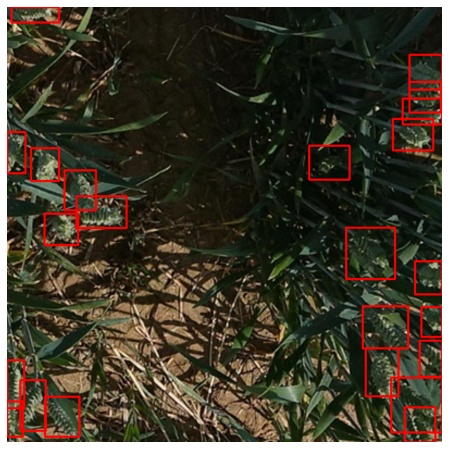

In [42]:
trained_model.eval()
trained_model.to(device)


images, targets, image_ids = next(iter(val_dataloader))

images = list(image.to(device,dtype=torch.float) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

fig,ax = plt.subplots(1,1,figsize=(16,8))

for box in boxes:
    cv2.rectangle(sample, (box[0],box[1]),(box[2],box[3]),(255,0,0),3)
    ax.set_axis_off()
    ax.imshow(sample)

## 7. Inference

In [43]:
class GlobalWheatDetectionTestDataset(torch.utils.data.Dataset):
    # first lets start with __init__ and initialize any objects
    def __init__(self,input_df,input_dir,transforms=None):
        
        self.df=input_df
        
        self.list_images = list(self.df['image_id'].unique())
        
        self.image_dir=input_dir
        
        self.transforms = transforms
    
    # next lets define __getitem__
    # very important to note what it returns for EACH image:
    # I. image - a PIL image of size (H,W) for ResNet50 FPN image should be scaled
    
    # II. image_id 
    
    def __getitem__(self,idx):
        
        # II. image_id
        img_id = self.list_images[idx]
        # I. Input image
        # Specifications: A.RGB format B. scaled (0,1) C. size (H,W) D. PIL format
        
        img = cv2.imread(self.image_dir+"/"+img_id+".jpg")
        img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_scaled = img_RGB/255.0
        img_final = img_scaled
        
        if self.transforms is not None:
            img_final = self.transforms(img_final)
        
        
        
        
        return img_final, img_id
    
    # next lets define __len__    
    def __len__(self):
        
        return len(self.df['image_id'].unique())

In [44]:
df_test=pd.read_csv("/kaggle/input/global-wheat-detection/sample_submission.csv")

In [45]:
df_test.head()

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50


In [46]:
# df_test['x0'] = df_test['bbox'].map(lambda x: x[1:-1].split(",")[0]).astype(float)
# df_test['y0'] = df_test['bbox'].map(lambda x: x[1:-1].split(",")[1]).astype(float)
# df_test['w'] = df_test['bbox'].map(lambda x: x[1:-1].split(",")[2]).astype(float)
# df_test['h'] = df_test['bbox'].map(lambda x: x[1:-1].split(",")[3]).astype(float)
# df_test['x1'] = df_test['x0'] + df_test['w']
# df_test['y1'] = df_test['y0'] + df_test['h']

In [47]:
test_dataset = GlobalWheatDetectionTestDataset(df_test,test_dir,get_transform())

In [48]:
test_dataloader = DataLoader(test_dataset, batch_size=8,shuffle=False, num_workers=2,collate_fn=collate_fn)

In [49]:
detection_threshold = 0.45

In [50]:
def format_prediction_string(boxes, scores): ## Define the formate for storing prediction results
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [51]:
device = torch.device('cuda')

In [52]:
## Lets make the prediction
results=[]
trained_model.eval()
images = []
outputs =[]
for images_, image_ids in test_dataloader:    

    images = list(image.to(device,dtype=torch.float) for image in images_)
    outputs = trained_model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()    ##Formate of the output's box is [Xmin,Ymin,Xmax,Ymax]
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32) #Compare the score of output with the threshold and
        scores = scores[scores >= detection_threshold]                    #slelect only those boxes whose score is greater
                                                                          # than threshold value
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]         
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]         #Convert the box formate to [Xmin,Ymin,W,H]
        
        
            
        result = {                                     #Store the image id and boxes and scores in result dict.
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)              #Append the result dict to Results list

test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


,image_id,PredictionString
0,aac893a91,0.9940 558 529 124 184 0.9874 616 912 75 106 0...
1,51f1be19e,0.9968 603 76 165 181 0.9917 498 456 211 112 0...
2,f5a1f0358,0.9948 136 748 160 121 0.9942 938 422 85 189 0...
3,796707dd7,0.9888 940 65 83 104 0.9872 894 325 115 91 0.9...
4,51b3e36ab,0.9965 700 603 317 138 0.9963 538 27 251 129 0...


In [53]:
#os.chdir("/kaggle/working")

In [54]:
test_df.to_csv('submission.csv', index=False)

In [55]:
# from IPython.display import FileLink
# FileLink(r'submission_1.csv')

In [56]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

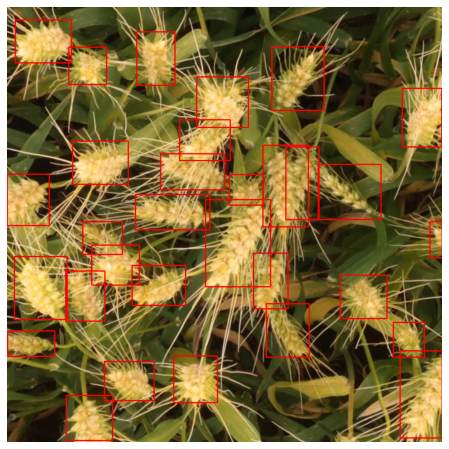

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)